In [1]:
import logging
import numpy as np
import pandas as pd

from memory import garbage_collect

log = lambda msg: logging.info(msg)


# Load data

In [2]:
input_dir = "C:\\dev\\play\\brainwave-data"


In [3]:
import stitch_pipeline_results
from importlib import reload
reload(stitch_pipeline_results)

df_orig = stitch_pipeline_results.stitch_all_days_optimised(input_dir, include_microwakings=False)
df = df_orig.copy()

  0%|          | 0/119 [00:00<?, ?it/s]

C:\dev\play\brainwave-processor\stitch_pipeline_results.py:158: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return post_stitch(pd.concat(all_dfs), should_remove_days_per_questionnaire)
C:\dev\play\brainwave-processor\stitch_pipeline_results.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 190.5  190.   189.5 ... -425.  -425.5 -426. ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[group.index, 'SSMinsUntilLongWake'] = (df.loc[first_long_wake_idx, 'Timestamp'] - df.loc[group.index, 'Timestamp']).dt.total_seconds() / 60


In [9]:
df['Main_eeg_std'].describe(percentiles=[0.9, 0.95, 0.99, 0.999])

count    93471.000000
mean         0.000135
std          0.001422
min          0.000000
50%          0.000021
90%          0.000101
95%          0.000274
99%          0.001044
99.9%        0.022780
max          0.087295
Name: Main_eeg_std, dtype: float64

In [50]:
eeg_only = [col for col in df.columns if "_eeg_" in col]
df_eeg = df_orig.copy()[eeg_only]

In [34]:
df_eeg.describe()

C:\Users\graha\.conda\envs\tf\lib\site-packages\numpy\core\_methods.py:49: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
C:\Users\graha\.conda\envs\tf\lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


,Main_eeg_abspow,Main_eeg_abspow_c7min_norm,Main_eeg_abspow_p2min_norm,Main_eeg_alpha,Main_eeg_alpha_c7min_norm,Main_eeg_alpha_p2min_norm,Main_eeg_alphaaa,Main_eeg_alphaaa_c7min_norm,Main_eeg_alphaaa_p2min_norm,Main_eeg_alphaab,...,Main_eeg_thetaab_p2min_norm_s,Main_eeg_thetaabs_s,Main_eeg_thetaabs_c7min_norm_s,Main_eeg_thetaabs_p2min_norm_s,Main_eeg_thetaabsaa_s,Main_eeg_thetaabsaa_c7min_norm_s,Main_eeg_thetaabsaa_p2min_norm_s,Main_eeg_thetaabsab_s,Main_eeg_thetaabsab_c7min_norm_s,Main_eeg_thetaabsab_p2min_norm_s
count,9.347100e+04,93471.000000,93471.000000,93438.000000,93452.000000,93441.000000,93438.000000,93452.000000,93441.000000,93438.000000,...,93441.000000,93471.000000,93471.000000,93471.000000,93471.000000,93471.000000,93471.000000,93471.000000,93471.000000,93471.000000
mean,3.978953e-10,0.086126,0.102459,0.054025,-0.029644,-0.003988,0.109841,-0.020327,0.002492,0.944530,...,0.499087,0.146019,0.196777,0.201012,0.166369,0.196124,0.209214,0.263325,0.277523,0.285396
std,4.568750e-10,0.189781,0.206415,0.038861,0.339305,0.338317,0.080802,0.332533,0.334008,0.057503,...,0.393488,0.164640,0.220476,0.223401,0.180031,0.197051,0.212211,0.343887,0.321422,0.346373
min,0.000000e+00,-0.224198,-0.208810,0.000007,-0.733886,-0.724918,0.000013,-0.784459,-0.724422,0.796875,...,-0.666881,-0.242606,-0.288394,-0.294233,-0.259735,-0.231506,-0.259311,-0.040733,-0.232208,-0.221521
25%,6.796731e-11,-0.046838,-0.040798,0.018461,-0.325319,-0.294078,0.038928,-0.287881,-0.271828,0.908329,...,0.215395,0.024418,0.054919,0.054170,0.035093,0.069882,0.070101,0.015269,0.051796,0.045324
50%,1.552399e-10,0.000019,0.000057,0.049287,-0.000840,-0.000771,0.098171,-0.000901,-0.000707,0.945929,...,0.496424,0.078961,0.105386,0.112658,0.097844,0.123180,0.132631,0.079281,0.130112,0.112823
75%,6.115834e-10,0.168832,0.196588,0.081259,0.215003,0.239261,0.162335,0.223104,0.242364,0.982632,...,0.803579,0.202434,0.283795,0.286439,0.231645,0.270807,0.289708,0.425693,0.418691,0.446949
max,1.427008e-09,0.492338,0.552666,0.175455,1.025485,1.039269,0.347446,0.989581,1.013651,1.094086,...,1.685855,0.469459,0.627108,0.634843,0.526473,0.572194,0.619119,1.041329,0.969034,1.049386


In [88]:
def clip_outliers_iqr(df, lower_percentile=0.001, upper_percentile=0.999, multiplier=0):
    clipped_counts = {}
    for column in df.columns:
        # if not column == 'Main_eeg_at':
        #     continue
        col = df[column]
        Q1 = col.quantile(lower_percentile)
        Q3 = col.quantile(upper_percentile)
        IQR = Q3 - Q1
        extra = multiplier * IQR
        lower_bound = Q1 - extra
        upper_bound = Q3 + extra
        lower_clipped = (col < lower_bound).sum()
        upper_clipped = (col > upper_bound).sum()
        col_clipped = col.clip(lower=lower_bound, upper=upper_bound)

        z_scores = (col - col.mean()) / col.std()
        z_scores_clipped = (col_clipped - col_clipped.mean()) / col_clipped.std()

        clipped_counts[column] = {
            'feature': column,
            'zscore > 2': (z_scores > 2).sum(),
            'zscore > 3': (z_scores > 3).sum(),
            'zscore > 4': (z_scores > 4).sum(),
            'zscore_clip > 2': (z_scores_clipped > 2).sum(),
            'zscore_clip > 3': (z_scores_clipped > 3).sum(),
            'zscore_clip > 4': (z_scores_clipped > 4).sum(),
            'lower_clipped': lower_clipped,
            'upper_clipped': upper_clipped,
            'total_clipped': lower_clipped + upper_clipped
        }
        df[column] = col_clipped

    return df, pd.DataFrame(clipped_counts).T

# Example usage
# df_clipped, clipped_summary = clip_outliers_iqr(df_eeg.copy(), 0.25, 0.75, 4)
df_clipped, clipped_summary = clip_outliers_iqr(df_eeg.copy(), 0.01, 0.99, 0)
clipped_summary

C:\Users\graha\.conda\envs\tf\lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
C:\Users\graha\.conda\envs\tf\lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
C:\Users\graha\.conda\envs\tf\lib\site-packages\numpy\core\_methods.py:49: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


,feature,zscore > 2,zscore > 3,zscore > 4,zscore_clip > 2,zscore_clip > 3,zscore_clip > 4,lower_clipped,upper_clipped,total_clipped
Main_eeg_abspow,Main_eeg_abspow,64,60,57,2673,2280,1528,935,935,1870
Main_eeg_abspow_c7min_norm,Main_eeg_abspow_c7min_norm,260,190,160,1209,1112,1070,935,935,1870
Main_eeg_abspow_p2min_norm,Main_eeg_abspow_p2min_norm,105,81,62,2238,1716,1388,935,935,1870
Main_eeg_alpha,Main_eeg_alpha,2585,863,453,3271,1004,0,935,935,1870
Main_eeg_alpha_c7min_norm,Main_eeg_alpha_c7min_norm,1726,312,85,1905,0,0,935,935,1870
...,...,...,...,...,...,...,...,...,...,...
Main_eeg_thetaabsaa_c7min_norm_s,Main_eeg_thetaabsaa_c7min_norm_s,377,316,278,1149,1073,1033,935,935,1870
Main_eeg_thetaabsaa_p2min_norm_s,Main_eeg_thetaabsaa_p2min_norm_s,191,171,157,3180,1996,1465,935,935,1870
Main_eeg_thetaabsab_s,Main_eeg_thetaabsab_s,64,59,56,2760,1774,1455,935,935,1870
Main_eeg_thetaabsab_c7min_norm_s,Main_eeg_thetaabsab_c7min_norm_s,264,198,162,1264,1123,1071,935,935,1870


In [26]:
clipped_summary[clipped_summary['feature'] == 'Main_eeg_std']

,feature,lower_clipped,upper_clipped,total_clipped
Main_eeg_std,Main_eeg_std,0,0,0


In [82]:
df_clipped['Main_eeg_std_c7min_norm'].describe(percentiles=[0.9, 0.95, 0.99, 0.999])

count    93471.000000
mean         0.357552
std          4.304063
min         -0.310291
50%          0.000000
90%          0.514062
95%          0.868045
99%          3.463405
99.9%       61.562492
max        304.532140
Name: Main_eeg_std_c7min_norm, dtype: float64

In [11]:
df['Main_eeg_std'].describe(percentiles=[0.9, 0.95, 0.99, 0.999])


count    93471.000000
mean         0.000135
std          0.001422
min          0.000000
50%          0.000021
90%          0.000101
95%          0.000274
99%          0.001044
99.9%        0.022780
max          0.087295
Name: Main_eeg_std, dtype: float64

In [87]:
df['Main_eeg_std_c7min_norm']

0        0.723854
1        0.763491
2        0.811791
3        0.815111
4        0.813442
           ...   
93466    0.361789
93467    0.430535
93468    0.455524
93469    0.490745
93470    0.493742
Name: Main_eeg_std_c7min_norm, Length: 93471, dtype: float64

AttributeError: Rectangle.set() got an unexpected keyword argument 'buckets'

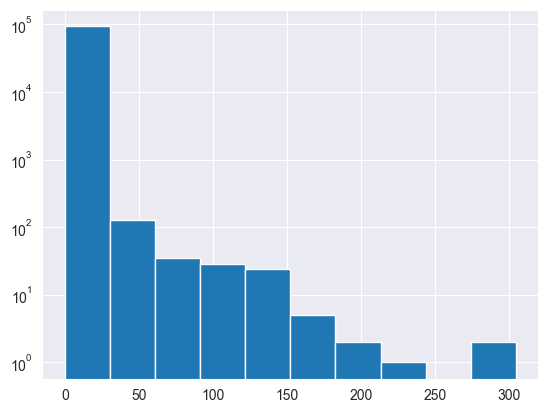

In [86]:
df['Main_eeg_std_c7min_norm'].hist(log=True)

In [90]:
df_clipped['Main_eeg_std'].describe()

count    93471.000000
mean         0.000060
std          0.000146
min          0.000006
25%          0.000012
50%          0.000021
75%          0.000034
max          0.001044
Name: Main_eeg_std, dtype: float64

<Axes: >

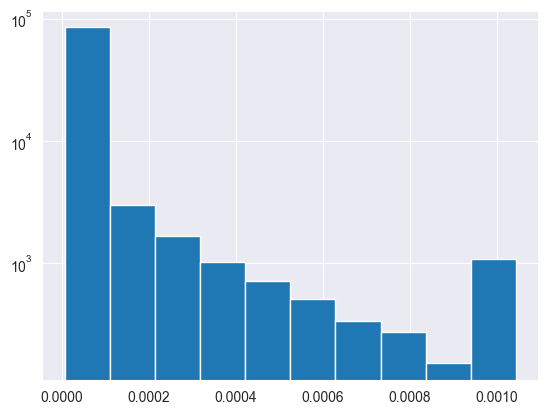

In [89]:
df_clipped['Main_eeg_std'].hist(log=True)

In [27]:
import pandas as pd

def count_clipped_values(df, lower_percentile, upper_percentile):
    clipped_counts = {}
    for column in df.columns:
        col = df[column]
        z_scores = (col - col.mean()) / col.std()
        lower_bound = col.quantile(lower_percentile)
        upper_bound = col.quantile(upper_percentile)
        lower_clipped = (col < lower_bound).sum()
        upper_clipped = (col > upper_bound).sum()
        col_clipped = col[(col >= lower_bound) & (col <= upper_bound)]
        z_scores_clipped = (col_clipped - col_clipped.mean()) / col_clipped.std()
        clipped_counts[column] = {
            # 'lower_clipped': lower_clipped,
            # 'upper_clipped': upper_clipped,
            'total_clipped': len(col_clipped) - len(col),
            'zscore_pre_clip': z_scores,
            'zscore_post_clip': z_scores_clipped,
        }

    return pd.DataFrame(clipped_counts).T

# Example usage
clipping_levels = [(0.001, 0.999), (0.01, 0.99), (0.05, 0.95)]
all_clipped_df = pd.DataFrame()

for lower, upper in clipping_levels:
    clipped_df = count_clipped_values(df_eeg, lower, upper)
    clipped_df['clipping_level'] = f"{lower*100}% - {upper*100}%"
    all_clipped_df = pd.concat([all_clipped_df, clipped_df])

all_clipped_df

C:\Users\graha\.conda\envs\tf\lib\site-packages\numpy\core\_methods.py:49: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
C:\Users\graha\.conda\envs\tf\lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
C:\Users\graha\.conda\envs\tf\lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
C:\Users\graha\.conda\envs\tf\lib\site-packages\numpy\core\_methods.py:49: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
C:\Users\graha\.conda\envs\tf\lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
C:\Users\graha\.conda\envs\tf\lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in sub

In [15]:
all_clipped_df['clipping_level'].unique()

array(['0.1% - 99.9%', '1.0% - 99.0%', '5.0% - 95.0%'], dtype=object)

In [16]:
all_clipped_df[all_clipped_df['clipping_level'] == '1.0% - 99.0%']

,lower_clipped,upper_clipped,total_clipped,clipping_level
Main_eeg_abspow,935,935,1870,1.0% - 99.0%
Main_eeg_abspow_c7min_norm,935,935,1870,1.0% - 99.0%
Main_eeg_abspow_p2min_norm,935,935,1870,1.0% - 99.0%
Main_eeg_alpha,935,935,1870,1.0% - 99.0%
Main_eeg_alpha_c7min_norm,935,935,1870,1.0% - 99.0%
...,...,...,...,...
Main_eeg_thetaabsaa_c7min_norm_s,935,935,1870,1.0% - 99.0%
Main_eeg_thetaabsaa_p2min_norm_s,935,935,1870,1.0% - 99.0%
Main_eeg_thetaabsab_s,935,935,1870,1.0% - 99.0%
Main_eeg_thetaabsab_c7min_norm_s,935,935,1870,1.0% - 99.0%


In [17]:
df.shape

(93471, 352)